## Pre requisites


*   A GCP account
*   CloudSQL with Postgres Engine
*   A DB in the CloudSQL


## Install packages

In [ ]:
!pip install asyncio==3.4.3 asyncpg==0.27.0 cloud-sql-python-connector["asyncpg"]==1.2.3
!pip install numpy==1.22.4 pandas==1.5.3
!pip install pgvector==0.1.8
!pip install langchain==0.0.196 transformers==4.30.1
!pip install google-cloud-aiplatform==1.26.0

## Setup Google Cloud environment

In [ ]:
# Please fill in these values.
project_id = ""  # @param {type:"string"}
database_password = ""  # @param {type:"string"}
region = ""  # @param {type:"string"}
instance_name = ""  # @param {type:"string"}
database_name = ""  # @param {type:"string"}
database_user = ""  # @param {type:"string"}


### Authenticate gcloud

In [ ]:
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {project_id}

# Grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

print(current_user)

## Load Data & Store to Postgres

In [ ]:
#  Load dataset from a web URL and store it in a pandas dataframe.

import pandas as pd
import os

DATASET_URL = "https://github.com/GoogleCloudPlatform/python-docs-samples/raw/main/cloud-sql/postgres/pgvector/data/retail_toy_dataset.csv"
df = pd.read_csv(DATASET_URL)
df = df.loc[:, ["product_id", "product_name", "description", "list_price"]]
df = df.dropna()
df.head(10)
print(df)

### Store data to postgres

In [ ]:
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database
        print("Connecting to DB.")
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("DROP TABLE IF EXISTS products CASCADE")
        # Create the `products` table.
        await conn.execute(
            """CREATE TABLE products(
                                product_id VARCHAR(1024) PRIMARY KEY,
                                product_name TEXT,
                                description TEXT,
                                list_price NUMERIC)"""
        )

        # Copy the dataframe to the `products` table.
        print("Copy the dataframe to the `products` table.")
        tuples = list(df.itertuples(index=False))
        await conn.copy_records_to_table(
            "products", records=tuples, columns=list(df), timeout=10
        )
        await conn.close()
        print("Successfully loaded data to `products` table.")

# Run the SQL commands now.
await main()  # type: ignore

Connecting to DB.


/usr/local/lib/python3.10/dist-packages/google/cloud/sql/connector/instance.py:330: CryptographyDeprecationWarning: Properties that return a naïve datetime object have been deprecated. Please switch to not_valid_after_utc.
  expiration = x509.not_valid_after


Copy the dataframe to the `products` table.
Successfully loaded data to `products` table.


## Vector Embeddings

### Understanding HLD (001)

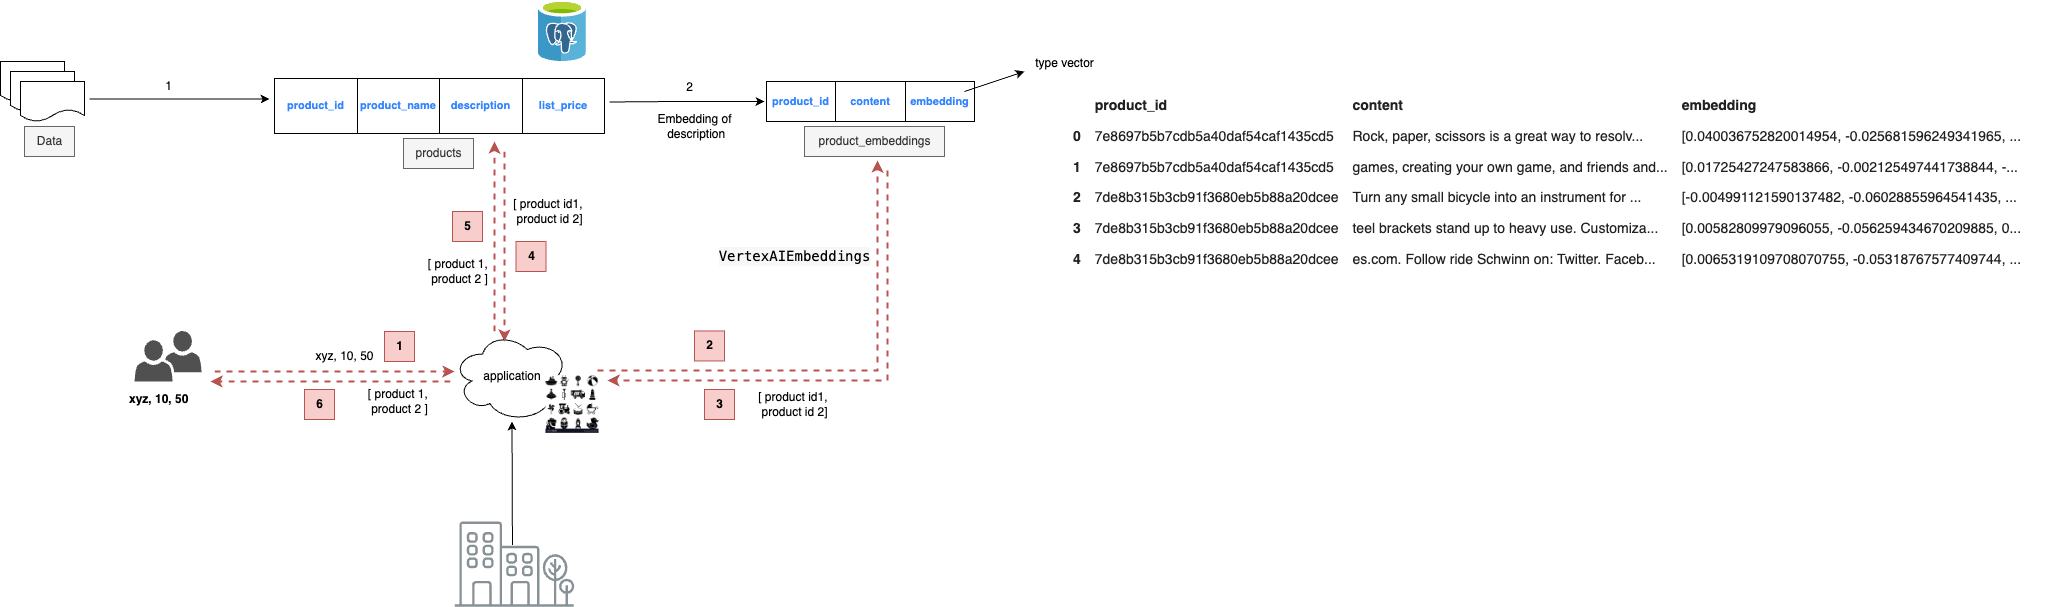

### Generate vector embeddings using a Text Embedding model

Step 1: Split long product description text into smaller chunks

- The product descriptions can be much longer than what can fit into a single API request for generating the vector embedding.

- For example, Vertex AI text embedding model accepts a maximum of 3,072 input tokens for a single API request.

- Use the `RecursiveCharacterTextSplitter` from LangChain library to split
the description into smaller chunks of 500 characters each.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[".", "\n"],
    chunk_size=500,
    chunk_overlap=0,
    length_function=len,
)
chunked = []
for index, row in df.iterrows():
    product_id = row["product_id"]
    desc = row["description"]
    splits = text_splitter.create_documents([desc])
    for s in splits:
        r = {"product_id": product_id, "content": s.page_content}
        chunked.append(r)
print(chunked)

Step 2: Generate vector embedding for each chunk by calling an Embedding Generation service

- In this demo, Vertex AI text embedding model is used to generate vector embeddings, which outputs a 768-dimensional vector for each chunk of text.

>⚠️ The following code snippet may run for a few minutes.

In [ ]:
# Generate the vector embeddings for each chunk of text.
# This code snippet may run for a few minutes.

from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform
import time

aiplatform.init(project=f"{project_id}", location=f"{region}")
embeddings_service = VertexAIEmbeddings()


# Helper function to retry failed API requests with exponential backoff.
def retry_with_backoff(func, *args, retry_delay=5, backoff_factor=2, **kwargs):
    max_attempts = 10
    retries = 0
    for i in range(max_attempts):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"error: {e}")
            retries += 1
            wait = retry_delay * (backoff_factor**retries)
            print(f"Retry after waiting for {wait} seconds...")
            time.sleep(wait)


batch_size = 5
for i in range(0, len(chunked), batch_size):
    print(f"Generating vector embedding for range {i} to {i+batch_size}")
    request = [x["content"] for x in chunked[i : i + batch_size]]
    response = retry_with_backoff(embeddings_service.embed_documents, request)
    # Store the retrieved vector embeddings for each chunk back.
    for x, e in zip(chunked[i : i + batch_size], response):
        x["embedding"] = e

# Store the generated embeddings in a pandas dataframe.
product_embeddings = pd.DataFrame(chunked)
product_embeddings.head()

### Use pgvector to store the generated embeddings within PostgreSQL

- The `pgvector` extension introduces a new `vector` data type.
- **The new `vector` data type allows you to directly save a vector embedding (represented as a NumPy array) through a simple INSERT statement in PostgreSQL!**

>⚠️ The following code snippet may run for a few minutes.

In [ ]:
# Store the generated vector embeddings in a PostgreSQL table.
# This code may run for a few minutes.

import asyncio
import asyncpg
from google.cloud.sql.connector import Connector
import numpy as np
from pgvector.asyncpg import register_vector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        print("Connecting to DB.")
        # Create connection to Cloud SQL database.
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await conn.execute("CREATE EXTENSION IF NOT EXISTS vector")
        await register_vector(conn)

        await conn.execute("DROP TABLE IF EXISTS product_embeddings")

        # Create the `product_embeddings` table to store vector embeddings.
        print("Creating the `product_embeddings` table to store vector embeddings.")
        await conn.execute(
            """CREATE TABLE product_embeddings(
                                product_id VARCHAR(1024) NOT NULL REFERENCES products(product_id),
                                content TEXT,
                                embedding vector(768))"""
        )

        # Store all the generated embeddings into the database.
        print("Storing all the generated embeddings into the database.")
        for index, row in product_embeddings.iterrows():
            await conn.execute(
                "INSERT INTO product_embeddings (product_id, content, embedding) VALUES ($1, $2, $3)",
                row["product_id"],
                row["content"],
                np.array(row["embedding"]),
            )

        await conn.close()
        print("Successfully loaded embeddings into the database.")

# Run the SQL commands now.
await main()  # type: ignore

### Create indexes for faster similarity search in pgvector

- Vector indexes can significantly speed up similarity search operation and avoid the brute-force exact nearest neighbor search that is used by default.

Enter or modify the values of index parameters for your index of choice and run the corresponding cell:

In [ ]:
# @markdown Create an HNSW index on the `product_embeddings` table:
m =  24 # @param {type:"integer"}
ef_construction = 100  # @param {type:"integer"}
operator =  "vector_cosine_ops"  # @param ["vector_cosine_ops", "vector_l2_ops", "vector_ip_ops"]

# Quick input validations.
assert m, "⚠️ Please input a valid value for m."
assert ef_construction, "⚠️ Please input a valid value for ef_construction."
assert operator, "⚠️ Please input a valid value for operator."

from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        print("Connecting to DB.")
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)

        # Create an HNSW index on the `product_embeddings` table.
        print("Creating an index on the `product_embeddings` table")
        await conn.execute(
            f"""CREATE INDEX ON product_embeddings
              USING hnsw(embedding {operator})
              WITH (m = {m}, ef_construction = {ef_construction})
            """
        )

        await conn.close()
        print("Index created successfully.")


# Run the SQL commands now.
await main()  # type: ignore

### Demo: Finding similar toy products using pgvector cosine search operator


In [ ]:
# @markdown Enter a short description of the toy to search for within a specified price range:
toy = "beach toy"  # @param {type:"string"}
min_price = 50  # @param {type:"integer"}
max_price = 100  # @param {type:"integer"}

# Quick input validations.
assert toy, "⚠️ Please input a valid input search text"

from langchain.embeddings import VertexAIEmbeddings
from google.cloud import aiplatform

aiplatform.init(project=f"{project_id}", location=f"{region}")

embeddings_service = VertexAIEmbeddings()
qe = embeddings_service.embed_query([toy])
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector

matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        print("Connecting to DB.")
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.1
        num_matches = 50

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        print("Searching for similar products using cosine similarity search over all vector embeddings.")
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT product_id, 1 - (embedding <=> $1) AS similarity
                              FROM product_embeddings
                              WHERE 1 - (embedding <=> $1) > $2
                              ORDER BY similarity DESC
                              LIMIT $3
                            )
                            SELECT product_name, list_price, description FROM products
                            WHERE product_id IN (SELECT product_id FROM vector_matches)
                            AND list_price >= $4 AND list_price <= $5
                            """,
            qe,
            similarity_threshold,
            num_matches,
            min_price,
            max_price,
        )

        if len(results) == 0:
            raise Exception("Did not find any results. Adjust the query parameters.")

        for r in results:
            # Collect the description for all the matched similar toy products.
            matches.append(
                {
                    "product_name": r["product_name"],
                    "description": r["description"],
                    "list_price": round(r["list_price"], 2),
                }
            )

        await conn.close()
        print(f"Search complete. Total number of items found {len(matches)}")


# Run the SQL commands now.
await main()  # type: ignore

# Show the results for similar products that matched the user query.
matches = pd.DataFrame(matches)
matches.head(5)

## LLMs and LangChain

### *Use case 1*: Building an AI-curated contextual hybrid search

Combine natural language query text with regular relational filters to create a powerful hybrid search.

Example: A grandparent wants to use the **AI-powered search interface** to find an educational toy for their grandkid that fits within their budget.



### Understanding HLD (002)

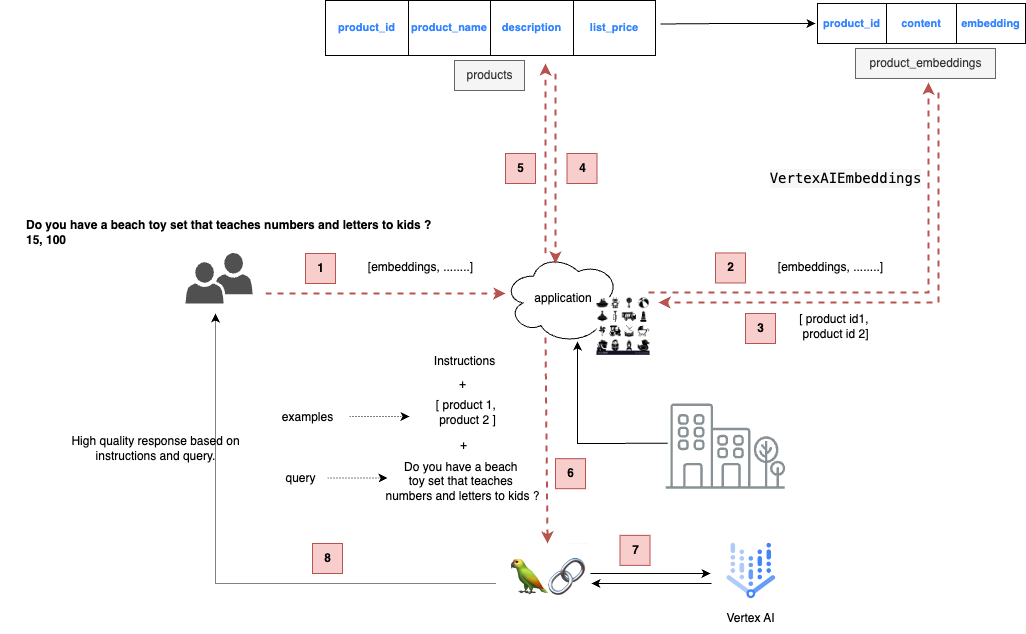

In [ ]:
# @markdown Enter the user search query in a simple English text. The price filters are shown separately here for demo purposes. These filters may represent additional input from your frontend application.
# Please fill in these values.
user_query = "Do you have a beach toy set that teaches numbers and letters to kids?"  # @param {type:"string"}
min_price = 15  # @param {type:"integer"}
max_price = 100  # @param {type:"integer"}

# Quick input validations.
assert user_query, "⚠️ Please input a valid input search text"

Step 1: Generate the vector embedding for the user query

In [ ]:
qe = embeddings_service.embed_query([user_query])
print(qe)

[-0.0001278111303690821, -0.03636414557695389, -0.028373708948493004, -0.030573436990380287, 0.05183436721563339, -0.0005275359726510942, 0.00768838869407773, -0.037158459424972534, 0.013988414779305458, 0.022561002522706985, 0.049604449421167374, 0.04192635416984558, -0.007578857708722353, -0.02717611752450466, -0.013751961290836334, -0.008998074568808079, 0.032518260180950165, -0.021827025339007378, 0.025168370455503464, -0.02341601997613907, 0.03468114137649536, 0.01741688698530197, 0.0039746519178152084, 0.023419633507728577, 0.023461194708943367, -0.03310462459921837, 0.026446858420968056, -0.03816990926861763, -0.029282735660672188, 0.04170455038547516, -0.05115801468491554, 0.043542373925447464, -0.035556476563215256, -0.03029162809252739, 0.048619892448186874, -0.05077115073800087, 0.04414846748113632, 0.00907298643141985, -0.017540201544761658, 0.025917505845427513, 0.040238432586193085, 0.0055494531989097595, -0.039747972041368484, -0.03452788293361664, -0.014577069319784641,

Step 2: Use `pgvector` to find similar products

- The new `pgvector` similarity search operators provide powerful semantics
to combine the vector search operation with regular query filters in a single SQL query.
- **Using pgvector, you can now seamlessly integrate the power of relational databases with your vector search operations!**


In [ ]:
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector

matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        print("Connecting to DB.")
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.7
        num_matches = 5

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        print("Searching for similar products using cosine similarity search over all vector embeddings.")
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT product_id, 1 - (embedding <=> $1) AS similarity
                              FROM product_embeddings
                              WHERE 1 - (embedding <=> $1) > $2
                              ORDER BY similarity DESC
                              LIMIT $3
                            )
                            SELECT product_name, list_price, description FROM products
                            WHERE product_id IN (SELECT product_id FROM vector_matches)
                            AND list_price >= $4 AND list_price <= $5
                            """,
            qe,
            similarity_threshold,
            num_matches,
            min_price,
            max_price,
        )

        if len(results) == 0:
            raise Exception("Did not find any results. Adjust the query parameters.")

        for r in results:
            # Collect the description for all the matched similar toy products.
            matches.append(
                f"""The name of the toy is {r["product_name"]}.
                          The price of the toy is ${round(r["list_price"], 2)}.
                          Its description is below:
                          {r["description"]}."""
            )
        await conn.close()
        print(f"Search complete. Total number of items found {len(results)}")


# Run the SQL commands now.
await main()  # type: ignore

# Show the results for similar products that matched the user query.
matches

Step 3: Use LangChain to summarize and generate a high-quality prompt to answer the user query

- After finding the similar products and their descriptions using `pgvector`, the next step is to use them for generating a prompt input for the LLM model.
- Since individual product descriptions can be very long, they may not fit within the specified input payload limit for an LLM model.
- The `MapReduceChain` from LangChain framework is used to generate and combine short summaries of similarly matched products.
- The combined summaries are then used to build a high-quality prompt for an input to the LLM model.

#### In below we:
*   Use prompt template to provide instructions to LLM
*   Provide a set of few sample examples to help the LLM generate a better response
*   Provide a question to the language model

In [ ]:
# Using LangChain for summarization and efficient context building.

from langchain.chains.summarize import load_summarize_chain
from langchain.docstore.document import Document
from langchain.llms import VertexAI
from langchain import PromptTemplate, LLMChain
from IPython.display import display, Markdown
from google.cloud import aiplatform

llm = VertexAI()

map_prompt_template = """
              You will be given a detailed description of a toy product.
              This description is enclosed in triple backticks (```).
              Using this description only, extract the name of the toy,
              the price of the toy and its features.

              ```{text}```
              SUMMARY:
              """
map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])

combine_prompt_template = """
                You will be given a detailed description different toy products
                enclosed in triple backticks (```) and a question enclosed in
                double backticks(``).
                Select one toy that is most relevant to answer the question.
                Using that selected toy description, answer the following
                question in as much detail as possible.
                You should only use the information in the description.
                Your answer should include the name of the toy, the price of the toy
                and its features. Your answer should be less than 200 words.
                Your answer should be in Markdown in a numbered list format.


                Description:
                ```{text}```


                Question:
                ``{user_query}``


                Answer:
                """
combine_prompt = PromptTemplate(
    template=combine_prompt_template, input_variables=["text", "user_query"]
)

docs = [Document(page_content=t) for t in matches]
chain = load_summarize_chain(
    llm, chain_type="map_reduce", map_prompt=map_prompt, combine_prompt=combine_prompt
)
answer = chain.run(
    {
        "input_documents": docs,
        "user_query": user_query,
    }
)

# print(docs)
# print(answer)
display(Markdown(answer))


 1. **Toy Name:** 14pcs Beach Tools Set Sand Playing Toys Kids Fun Water Beach Seaside Tools Gifts

2. **Price:** $16.67

3. **Features:**

- This beach toy set does not have any educational features such as teaching numbers or letters.
- It focuses on promoting creativity and imaginative play through its unique shapes and bright colors.
- It includes various beach tools such as shovels, rakes, and molds for sand play.
- It is suitable for use at beaches, sandboxes, seasides, swimming pools, and bathtubs.
- It makes a

### _Use case 2_: Adding AI-powered creative content generation

Use knowledge from the existing dataset to generate new AI-powered content from an initial prompt.

Example: A third-party seller on the retail platform wants to use the **AI-powered content generation** to create a detailed description of their new bicycle product.

### Understanding HLD (003)

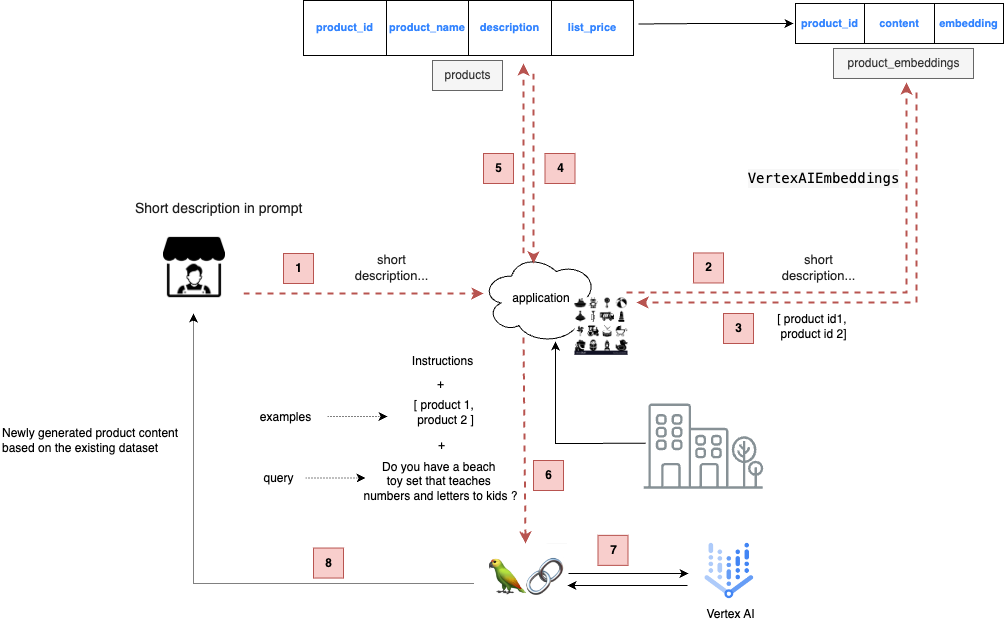

In [ ]:
# @markdown Describe your a new product in just a few words:
# Please fill in these values.
creative_prompt = "A bicycle with brand name 'Roadstar bike' for kids that comes with training wheels and helmet."  # @param {type:"string"}

# Quick input validations.
assert creative_prompt, "⚠️ Please input a valid input search text"

Step 1: Find an existing product description matching the initial prompt

- Leverage the `pgvector` similarity search operator to find an existing
product description that closely matches the new product specified
in the initial prompt.

In [ ]:
from pgvector.asyncpg import register_vector
import asyncio
import asyncpg
from google.cloud.sql.connector import Connector

qe = embeddings_service.embed_query([creative_prompt])
qe_str = "[%s]" % (",".join([str(x) for x in qe]))
matches = []


async def main():
    loop = asyncio.get_running_loop()
    async with Connector(loop=loop) as connector:
        # Create connection to Cloud SQL database.
        print("Connecting to DB.")
        conn: asyncpg.Connection = await connector.connect_async(
            f"{project_id}:{region}:{instance_name}",  # Cloud SQL instance connection name
            "asyncpg",
            user=f"{database_user}",
            password=f"{database_password}",
            db=f"{database_name}",
        )

        await register_vector(conn)
        similarity_threshold = 0.7

        # Find similar products to the query using cosine similarity search
        # over all vector embeddings. This new feature is provided by `pgvector`.
        print("Find similar products to the query using cosine similarity search over all vector embeddings.")
        results = await conn.fetch(
            """
                            WITH vector_matches AS (
                              SELECT product_id, 1 - (embedding <=> $1) AS similarity
                              FROM product_embeddings
                              WHERE 1 - (embedding <=> $2) > $3
                              ORDER BY similarity DESC
                              LIMIT 1
                            )
                            SELECT description FROM products
                            WHERE product_id IN (SELECT product_id FROM vector_matches)
                            """,
            qe,
            qe,
            similarity_threshold,
        )

        for r in results:
            matches.append(r["description"])

        await conn.close()
        print("Search complete.")


# Run the SQL commands now.
await main()  # type: ignore

# Show the matched product description.
matches

Step 2: Use the existing matched product description as the prompt context to generate new creative output from the LLM.


In [ ]:
from langchain.llms import VertexAI
from langchain import PromptTemplate, LLMChain
from IPython.display import display, Markdown

template = """
            You are given descriptions about some similar kind of toys in the context.
            This context is enclosed in triple backticks (```).
            Combine these descriptions and adapt them to match the specifications in
            the initial prompt. All the information from the initial prompt must
            be included. You are allowed to be as creative as possible,
            and describe the new toy in as much detail. Your answer should be
            less than 200 words.

            Context:
            ```{context}```

            Initial Prompt:
            {creative_prompt}

            Answer:
        """

prompt = PromptTemplate(
    template=template, input_variables=["context", "creative_prompt"]
)

# Increase the `temperature` to allow more creative writing freedom.
llm = VertexAI(temperature=0.7)

llm_chain = LLMChain(prompt=prompt, llm=llm)
answer = llm_chain.run(
    {
        "context": "\n".join(matches),
        "creative_prompt": creative_prompt,
    }
)


display(Markdown(answer))